# Overlapping densities - Work in Progress

In [1]:
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

df = pd.read_pickle("../data/ridgeplot_data.pkl")

outcome = df[["qoi"]].copy()

features = df.drop("qoi", axis=1)
features = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)

distances = features.apply(lambda row: np.linalg.norm(row), axis=1).to_frame("distance")
distances["group"] = pd.cut(
    x=distances["distance"],
    bins=[0, 6, 8, 9, 10, 11, 12, 14, int(distances["distance"].max()) + 1],
)

data_tmp = pd.concat((outcome, distances[["group"]]), axis=1)
outcome["group"] = pd._libs.interval.Interval(0, 16)
data = pd.concat((data_tmp, outcome), axis=0)

def ridge_plot_seaborn(df):
    """Ridge plot usign seaborn.

    Args:
        df (pd.DataFrame): Data frame containing a value column (name passed as
            argument), and a group column (must be called "group"), that classifies each
            row to a single group. Note that the group must be categorical.

    """
    sns.set(
        style="white",
        rc={
            "axes.facecolor": (0, 0, 0, 0),
            "axes.labelsize": 16.0,
            "xtick.labelsize": 16.0,
        },
    )

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-0.3, light=0.7)
    g = sns.FacetGrid(df, row="group", hue="group", aspect=15, height=1, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "qoi", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.025)
    g.map(sns.kdeplot, "qoi", clip_on=False, color="w", lw=2, bw=0.025)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            fontsize=14,
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))

    g.map(label)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.25)

    g.axes[0][-1]

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

def _grouper(series):
    """Extract unique groups from series and order.

    For my application I need the elements to be sorted using classical sort, but
    on top I need the complete interval (0, 16] to be the first element.

    Args:
        series (pd.Series): The series from which the unique elements are selected.

    Returns:
        unique (list): The unique elements ordered.

    """
    unique = np.sort(series.unique()).tolist()
    unique[0], unique[1] = unique[1], unique[0]
    return unique

def ridge_plot(
    df,
    groups,
    value_col="qoi",
    xlim=(-0.2, 1),
    figsize=(16, 10),
    col_palette=None,
    bw=0.015,
    kernel="epanechnikov",
    first_group_is_complete=True,
    ticker_value=0.25,
    hspace=-0.25,
    publication_ready=False,
):
    """Create overlapping densities plot.

    Args:
        df (pd.DataFrame): Data frame containing a value column (name passed as
            argument), and a group column (must be called "group"), that classifies each
            row to a single group. Note that the group must be categorical.
        groups (list): List of unique group names contained in df["group"]. The order of
            this list determines the order of the subplots.
        value_col (str): Name of value column.
        xlim (tuple): x-axis limits.
        figsize (tuple): Figure size.
        col_palette (list): Color palette. If None, defaults to
            itertools.cycle(seaborn.cubehelix_palette(10, rot=-.3, light=.7)).
        bw (float): Bandwidth for the density estimation kernel.
        first_group_is_complete (bool): If after getting the unique ordered groups the
            first group represents the complete sample.
        ticker_value (float): Float passed to matplotlib.ticker.MultipleLocator.
        hspace (float): Float passed to grid_spec.GridSpec().update.
        publication_ready (bool): If True the plot is generated in black and white.

    Returns:
        fig (matplotlib.figure.Figure): The ridge plot figure.

    """
    if col_palette is None:
        col_palette = itertools.cycle(
            [
                [0.5542728401165395, 0.7695111327768686, 0.7424293850239434],
                [0.48074132506944434, 0.7076550245279908, 0.7043336083684792],
                [0.415619966862078, 0.6415373688838383, 0.6661585119301697],
                [0.36187657462305156, 0.5762587041377625, 0.6281032312096417],
                [0.3115422795524257, 0.5039229399475449, 0.5829515566874145],
                [0.2671682478057056, 0.42979148038743764, 0.5311760948785271],
                [0.22950098402102104, 0.35967733834707893, 0.47521262123396524],
                [0.19163415868814648, 0.2853905664320337, 0.406523236809716],
                [0.15636032025364718, 0.21730746943680534, 0.3331383745960979],
                [0.11670781642374867, 0.14752211647373256, 0.24517491899857707],
            ]
        )
    else:
        col_palette = itertools.cycle(col_palette)

    n_groups = len(groups)
    n_obs = len(df) / 2 if first_group_is_complete else len(df)

    gs = grid_spec.GridSpec(n_groups, 1)
    fig = plt.figure(figsize=figsize)

    kde = KernelDensity(kernel=kernel, bandwidth=bw)

    for i, g in enumerate(groups):
        color = "tan" if i == 0 and first_group_is_complete else next(col_palette)
        options = (
            ("black", "white", "black", "black", 1, None),
            ("white", color, color, color, 1.5, "bold")
        )
        edgecol, facecol, fontcol, hlinecol, hlinelw, fontweight = options[0] if publication_ready else options[1]

        # create plotting data
        data = df.query("group==@g")[value_col].to_numpy()
        freq = (len(data) / n_obs) * 100

        # train kernel density estimator and evaluate on grid
        kde.fit(data[:, None])
        x = np.linspace(xlim[0], xlim[1], 500)
        log_prob = kde.score_samples(x[:, None])
        density = np.exp(log_prob)

        # creating new axes object for each group
        ax = fig.add_subplot(gs[i : i + 1, 0:])  # noqa: E203

        # actual plotting
        kwargs = {"hatch": "//"} if i == 0 and first_group_is_complete else {}
        ax.fill_between(
            x, density, 0, edgecolor=edgecol, facecolor=facecol, lw=1.5, **kwargs
        )
        ax.axhline(y=0, lw=hlinelw, clip_on=False, color=hlinecol)

        # set xlim
        ax.set_xlim(*xlim)

        # make background transparent
        rect = ax.patch
        rect.set_alpha(0)

        # remove axis ticks, labels and borders
        ax.set_yticklabels([])
        if i != n_groups - 1:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_value))

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)

        # add group text, percentages (this need changing depending on the application)
        fontweight = "bold" if i == 0 else fontweight
        ax.text(
            -0.1, 1.5, g, fontweight=fontweight, fontsize=14, ha="right", color=fontcol
        )
        ax.text(
            1,
            1.5,
            f"{freq:.1f}%",
            fontweight=fontweight,
            fontsize=14,
            ha="right",
            color=fontcol,
        )

    gs.update(hspace=hspace)
    return fig

In [36]:
groups = _grouper(data["group"])

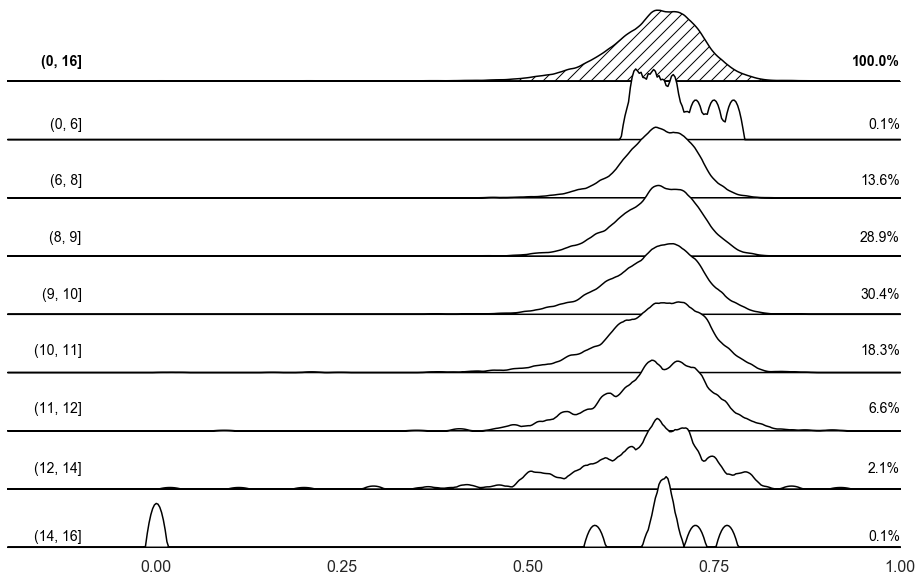

In [37]:
fig = ridge_plot(data, groups, publication_ready=True)